# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped

FOLDERNAME = 'Sergey Levine - Deep Learning/hw1/deeplearning/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Sergey Levine - Deep Learning/hw1/deeplearning


In [2]:
!python setup.py build_ext --inplace

Compiling im2col_cython.pyx because it depends on /usr/local/lib/python3.7/dist-packages/Cython/Includes/libc/string.pxd.
[1/1] Cythonizing im2col_cython.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/Sergey Levine - Deep Learning/hw1/deeplearning/im2col_cython.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'im2col_cython' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-pX47U3/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-pX47U3/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I/usr/include/pyt

In [3]:
%cd datasets/
!bash get_datasets.sh

/content/drive/My Drive/Sergey Levine - Deep Learning/hw1/deeplearning/datasets
--2022-03-04 12:07:37--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  29.3MB/s    in 6.4s    

2022-03-04 12:07:44 (25.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
%cd ../..

/content/drive/MyDrive/Sergey Levine - Deep Learning/hw1


In [7]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from deeplearning.classifiers.fc_net import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [8]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print ('%s: ' % k, v.shape)

deeplearning/datasets/cifar-10-batches-py/data_batch_1
deeplearning/datasets/cifar-10-batches-py/data_batch_2
deeplearning/datasets/cifar-10-batches-py/data_batch_3
deeplearning/datasets/cifar-10-batches-py/data_batch_4
deeplearning/datasets/cifar-10-batches-py/data_batch_5
deeplearning/datasets/cifar-10-batches-py/test_batch
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `deeplearning/layers.py`, implement the forward pass for (inverted) dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes. Input means should be approximately the same as the output means at both train/test time.

Once you have done so, run the cell below to test your implementation.

In [11]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print ('Running tests with p = ', p)
    print ('Mean of input: ', x.mean())
    print ('Mean of train-time output: ', out.mean())
    print ('Mean of test-time output: ', out_test.mean())
    print ('Fraction of train-time output set to zero: ', (out == 0).mean())
    print ('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print

Running tests with p =  0.3
Mean of input:  9.998103791491856
Mean of train-time output:  10.028435764054624
Mean of test-time output:  9.998103791491856
Fraction of train-time output set to zero:  0.297928
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.998103791491856
Mean of train-time output:  10.016463173878941
Mean of test-time output:  9.998103791491856
Fraction of train-time output set to zero:  0.5995
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.998103791491856
Mean of train-time output:  10.022796651729397
Mean of test-time output:  9.998103791491856
Fraction of train-time output set to zero:  0.749496
Fraction of test-time output set to zero:  0.0


# Dropout backward pass
In the file `deeplearning/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [12]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print ('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.892909139413003e-11


# Fully-connected nets with Dropout
In the file `deeplearning/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [14]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
np.random.seed(124)
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print ('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)
    
    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print

Running check with dropout =  0
Initial loss:  2.299032598417055
W1 relative error: 8.86e-07
W2 relative error: 8.60e-07
W3 relative error: 5.69e-08
b1 relative error: 1.69e-08
b2 relative error: 6.21e-08
b3 relative error: 5.10e-11
Running check with dropout =  0.25
Initial loss:  2.3002568004999215
W1 relative error: 5.90e-07
W2 relative error: 1.59e-05
W3 relative error: 2.00e-08
b1 relative error: 6.76e-09
b2 relative error: 3.76e-08
b3 relative error: 1.16e-10
Running check with dropout =  0.5
Initial loss:  2.3031269151254037
W1 relative error: 1.22e-07
W2 relative error: 3.75e-08
W3 relative error: 1.33e-08
b1 relative error: 6.01e-09
b2 relative error: 5.65e-08
b3 relative error: 1.34e-10


# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [17]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print (dropout)

    solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 7.875809
(Epoch 0 / 25) train acc: 0.212000; val_acc: 0.158000


/content/drive/MyDrive/Sergey Levine - Deep Learning/hw1/deeplearning/layers.py:567: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Epoch 1 / 25) train acc: 0.448000; val_acc: 0.289000
(Epoch 2 / 25) train acc: 0.550000; val_acc: 0.279000
(Epoch 3 / 25) train acc: 0.638000; val_acc: 0.258000
(Epoch 4 / 25) train acc: 0.682000; val_acc: 0.241000
(Epoch 5 / 25) train acc: 0.760000; val_acc: 0.294000
(Epoch 6 / 25) train acc: 0.808000; val_acc: 0.268000
(Epoch 7 / 25) train acc: 0.838000; val_acc: 0.274000
(Epoch 8 / 25) train acc: 0.888000; val_acc: 0.271000
(Epoch 9 / 25) train acc: 0.900000; val_acc: 0.295000
(Epoch 10 / 25) train acc: 0.894000; val_acc: 0.291000
(Epoch 11 / 25) train acc: 0.930000; val_acc: 0.280000
(Epoch 12 / 25) train acc: 0.912000; val_acc: 0.272000
(Epoch 13 / 25) train acc: 0.950000; val_acc: 0.295000
(Epoch 14 / 25) train acc: 0.966000; val_acc: 0.292000
(Epoch 15 / 25) train acc: 0.970000; val_acc: 0.293000
(Epoch 16 / 25) train acc: 0.986000; val_acc: 0.307000
(Epoch 17 / 25) train acc: 0.978000; val_acc: 0.292000
(Epoch 18 / 25) train acc: 0.990000; val_acc: 0.320000
(Epoch 19 / 25) tra

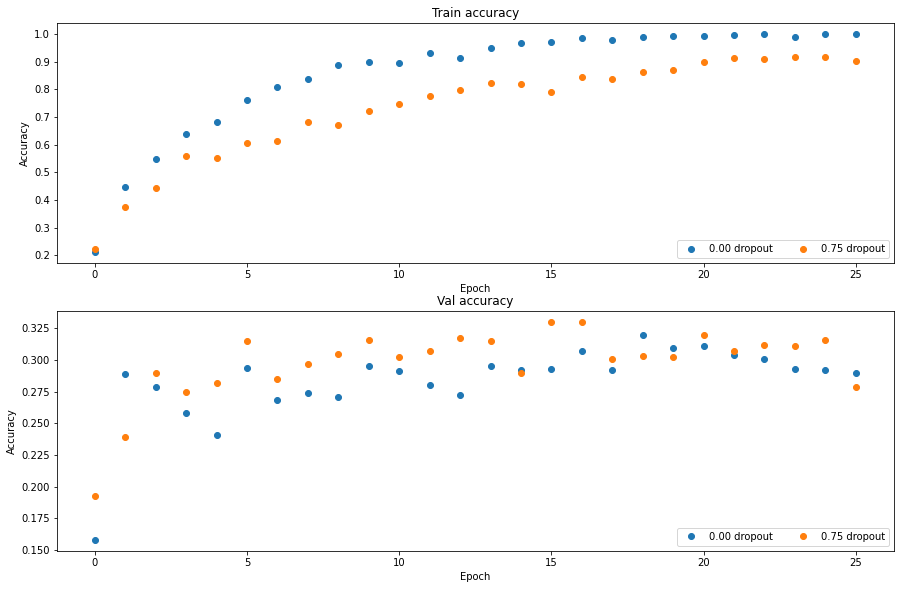

In [18]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])
    solver.record_histories_as_npz('submission_logs/dropout_regularization_experiment_p{}.npz'.format(dropout))

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Explain what you see in this experiment. What does it suggest about dropout?

# Answer
